In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [5]:
#generate data

x_s = np.linspace(-5,5, 30)
y_s = np.linspace(-5,5, 30)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


13500

In [6]:
X_grid

array([[-5.        , -5.        ,  0.        ],
       [-5.        , -5.        ,  0.44879895],
       [-5.        , -5.        ,  0.8975979 ],
       ...,
       [ 5.        ,  5.        ,  5.385587  ],
       [ 5.        ,  5.        ,  5.8343863 ],
       [ 5.        ,  5.        ,  6.2831855 ]], dtype=float32)

In [7]:


def uniform_samples(env, n):

    state = env.reset()
    X_rand = []
    for i in range(n):
        state = env.reset()
        X_rand.append(state)
        for action in range(env.action_space.n):
            next_state, reward, done, _ = env.step(state, action, update_env=False)
            X_rand.append(next_state)
    return np.array(X_rand)


X = uniform_samples(env, 1)
X_val = uniform_samples(env,2000)


In [8]:
X = np.vstack([X_grid])
np.random.shuffle(X)
#X = np.flip(X,0)
len(X)

13500

In [9]:
def filter(X, get_y=None):
    filted_X = []
    for x in X:
        # calculate distance to goal and obstacle
        dist_obstacle = np.linalg.norm(x[:2] - env.obstacle_position) - env.obstacle_radius
        if dist_obstacle > 0: 
            dist_goal = np.linalg.norm(x[:2] - env.goal_position) - env.min_distance_to_goal
            if dist_goal > 0:
                filted_X.append(x)
    return np.array(filted_X)

#X = filter(X)

In [10]:
ys = [env.get_reward(x) for x in X]
    
ys = np.array(ys)

In [11]:
max(ys)

1

In [12]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if y_pred:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'


    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    #plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


In [13]:
len(X)

13500

In [14]:
env.step(np.array([-2,2,np.pi]),1)

(array([-2.22590499,  2.10708378,  3.14159265]), 0, False, {})

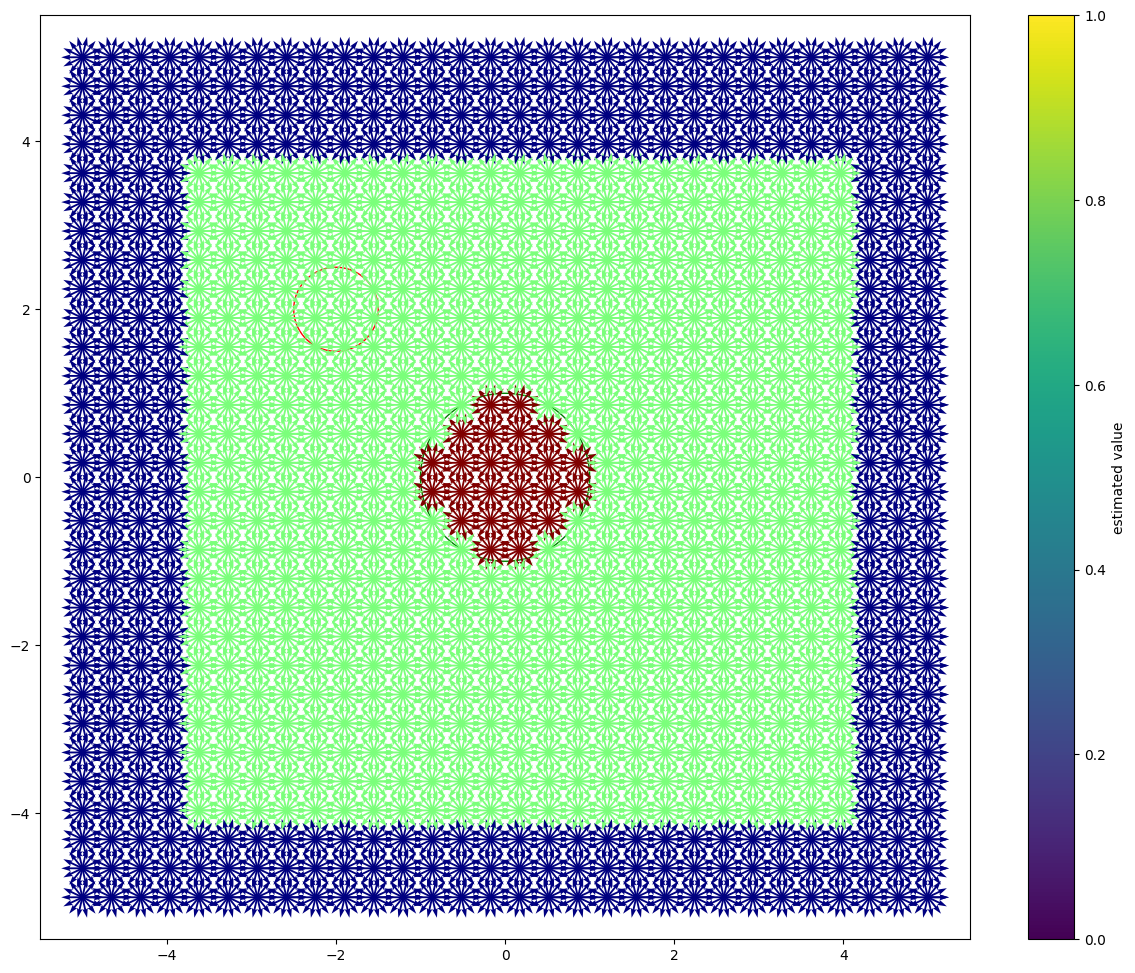

In [15]:
plot_surface(X, env, None, None, ys)

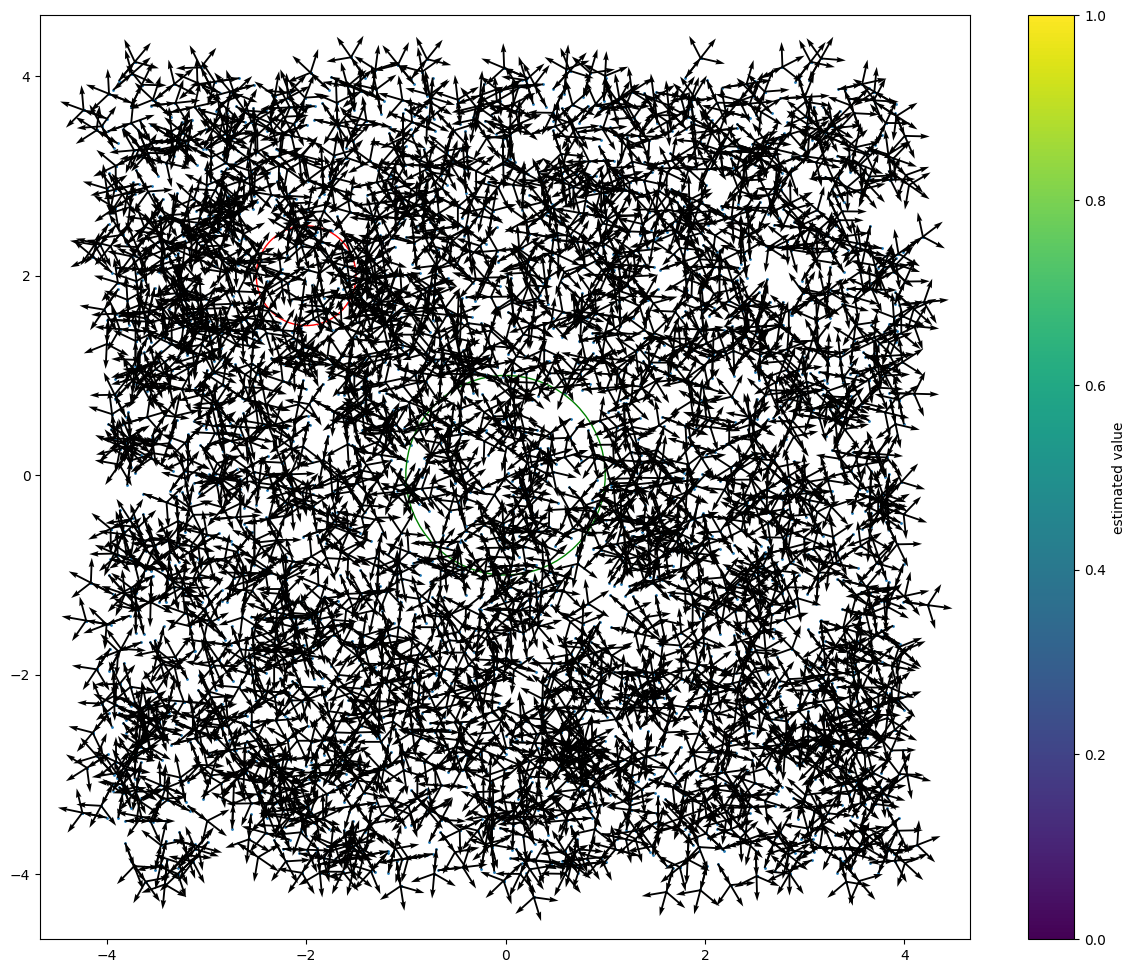

In [39]:
plot_surface(X_val, env, ys=[])

In [16]:
X3 = X.copy()
X_val3 = X_val.copy()
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X_val = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))




In [17]:
X

array([[-0.86206895, -0.86206895,  0.6234898 ,  0.7818315 ],
       [-1.5517242 , -0.1724138 ,  0.22252098,  0.9749279 ],
       [-1.8965517 , -0.1724138 , -0.6234896 , -0.7818316 ],
       ...,
       [-0.1724138 , -2.9310346 ,  0.22252098,  0.9749279 ],
       [ 5.        ,  2.586207  , -0.6234898 ,  0.7818315 ],
       [-5.        ,  0.86206895, -0.22252095,  0.9749279 ]],
      dtype=float32)

In [16]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.adabelief(learning_rate=10e-6)
batch_size = 100 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    batch_loss = []
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.8)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        #print("progress:", "epoch:", epoch, "batch loss",loss)
        batch_loss.append(loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    losses.append(np.mean(batch_loss))
    print('epoch', epoch, 'average loss', np.mean(batch_loss))
        
    
    
# After training
print("estimation of the parameters:")
print(params)

# estimate  = forward(X=env.reset(), params=params)
# print("estimate", estimate)

epoch 0 average loss 0.82372934
epoch 1 average loss 0.8000456
epoch 2 average loss 0.7731888
epoch 3 average loss 0.7463469
epoch 4 average loss 0.720643
epoch 5 average loss 0.696386
epoch 6 average loss 0.673724
epoch 7 average loss 0.65266436
epoch 8 average loss 0.63318217
epoch 9 average loss 0.6152161
epoch 10 average loss 0.59865654
epoch 11 average loss 0.5833821
epoch 12 average loss 0.56936127
epoch 13 average loss 0.55646914
epoch 14 average loss 0.54464597
epoch 15 average loss 0.5337746
epoch 16 average loss 0.52379775
epoch 17 average loss 0.5146231
epoch 18 average loss 0.50616807


KeyboardInterrupt: 

In [42]:

def forward(X):
    l1 = hk.Linear(64)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(64)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(64)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adamw(learning_rate=10e-6)
batch_size = 5 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.8

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = False

for epoch in range(100):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = True
    epoch_loss /= (len(X) // batch_size)

    y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    val_loss = loss_fn(params, X_val, y_val)
    print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    if val_losses[-1] - val_loss < 0.0001:
        print("early stopping",val_losses[-1] - val_loss)
        break
    val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


val_loss 0.40873876 delta inf
epoch 0 average loss 0.65810376 epoch delta inf
val_loss 0.16003254 delta 0.24870622
epoch 1 average loss 0.36068124 epoch delta 0.29742253
val_loss 0.15519261 delta 0.004839927
epoch 2 average loss 0.28490123 epoch delta 0.075780004
val_loss 0.15295127 delta 0.0022413433
epoch 3 average loss 0.2838659 epoch delta 0.0010353327
val_loss 0.15127276 delta 0.0016785115
epoch 4 average loss 0.2833816 epoch delta 0.00048428774
val_loss 0.14999479 delta 0.0012779683
epoch 5 average loss 0.2830782 epoch delta 0.00030341744
val_loss 0.14889431 delta 0.0011004806
epoch 6 average loss 0.2828594 epoch delta 0.00021877885
val_loss 0.14800192 delta 0.00089238584
epoch 7 average loss 0.28268787 epoch delta 0.00017154217
val_loss 0.14720242 delta 0.0007995069
epoch 8 average loss 0.28255033 epoch delta 0.00013753772
val_loss 0.14652842 delta 0.0006739944
epoch 9 average loss 0.28243306 epoch delta 0.00011727214
val_loss 0.14597052 delta 0.0005578995
epoch 10 average loss 

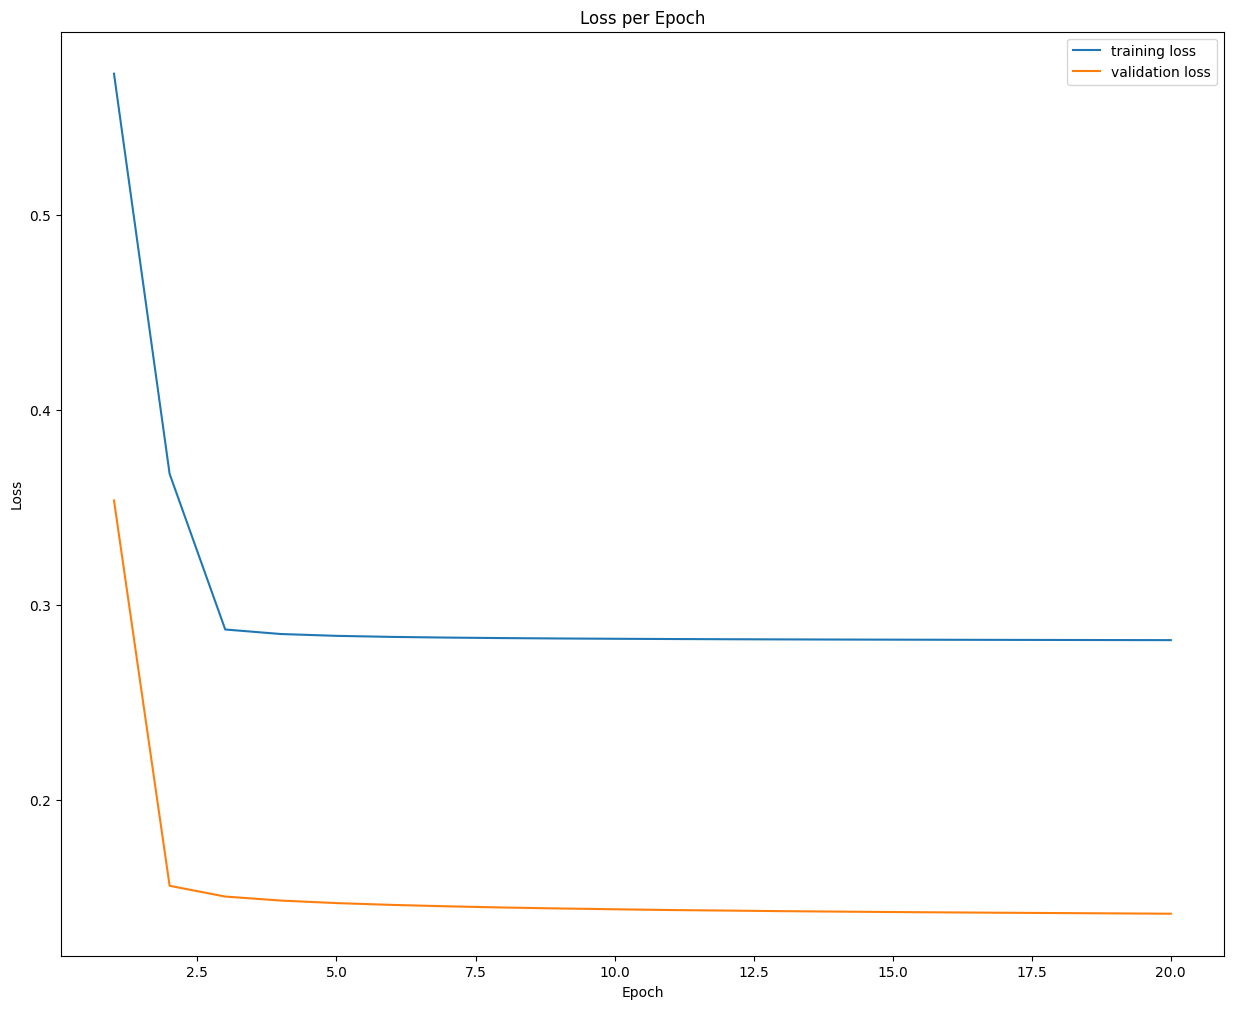

In [23]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [24]:
#generate data

x_s = np.linspace(-5,5, 20)
y_s = np.linspace(-5,5, 20)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_test = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_test = []
for i in range(len(grid_test)):
    state = env.set(grid_test[i][0], grid_test[i][1], grid_test[i][2])
    X_test.append(state)

X_test = np.array(X_test)

X_test_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_test)))
X_test_encoded

array([[-5.0000000e+00, -5.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [-5.0000000e+00, -5.0000000e+00,  9.0096885e-01,  4.3388376e-01],
       [-5.0000000e+00, -5.0000000e+00,  6.2348980e-01,  7.8183150e-01],
       ...,
       [ 5.0000000e+00,  5.0000000e+00,  6.2348962e-01, -7.8183162e-01],
       [ 5.0000000e+00,  5.0000000e+00,  9.0096885e-01, -4.3388376e-01],
       [ 5.0000000e+00,  5.0000000e+00,  1.0000000e+00,  1.7484555e-07]],
      dtype=float32)

In [43]:



y_pred = [forward(X=x, params=params) for x in X_test_encoded]

In [44]:
y_pred

[Array([-0.5306512], dtype=float32),
 Array([-0.5353429], dtype=float32),
 Array([-0.53309256], dtype=float32),
 Array([-0.53345186], dtype=float32),
 Array([-0.5345208], dtype=float32),
 Array([-0.52862084], dtype=float32),
 Array([-0.52350724], dtype=float32),
 Array([-0.52229476], dtype=float32),
 Array([-0.535941], dtype=float32),
 Array([-0.54001397], dtype=float32),
 Array([-0.5588237], dtype=float32),
 Array([-0.54921985], dtype=float32),
 Array([-0.53982174], dtype=float32),
 Array([-0.53525007], dtype=float32),
 Array([-0.53065115], dtype=float32),
 Array([-0.5129613], dtype=float32),
 Array([-0.51200056], dtype=float32),
 Array([-0.5227353], dtype=float32),
 Array([-0.5063091], dtype=float32),
 Array([-0.4993083], dtype=float32),
 Array([-0.51716137], dtype=float32),
 Array([-0.49527055], dtype=float32),
 Array([-0.48995894], dtype=float32),
 Array([-0.5035601], dtype=float32),
 Array([-0.5194228], dtype=float32),
 Array([-0.52853537], dtype=float32),
 Array([-0.5289941], dty

In [45]:
max(y_pred)

Array([-0.06734919], dtype=float32)

In [46]:
min(y_pred)

Array([-0.5813739], dtype=float32)

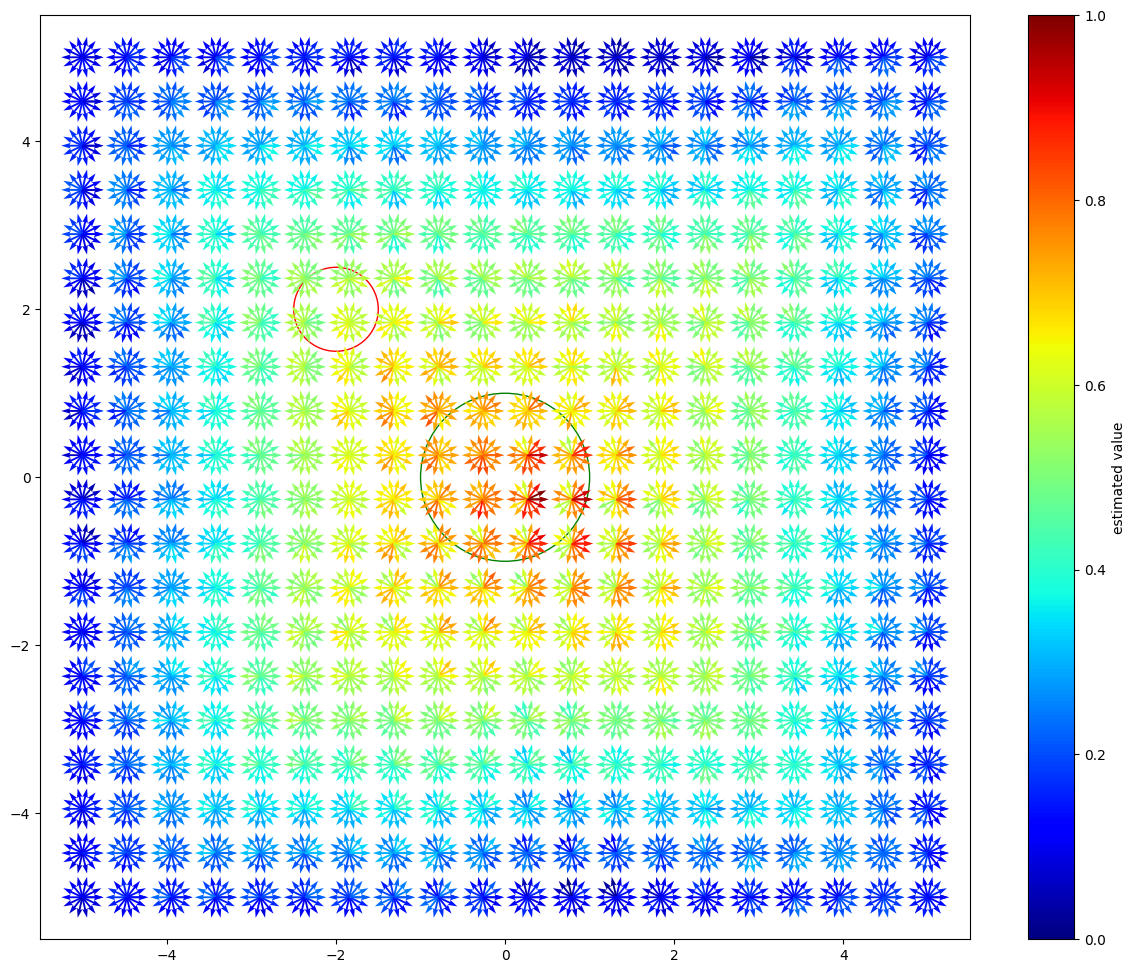

In [47]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [48]:
y_train = [forward(X=x, params=params) for x in X]

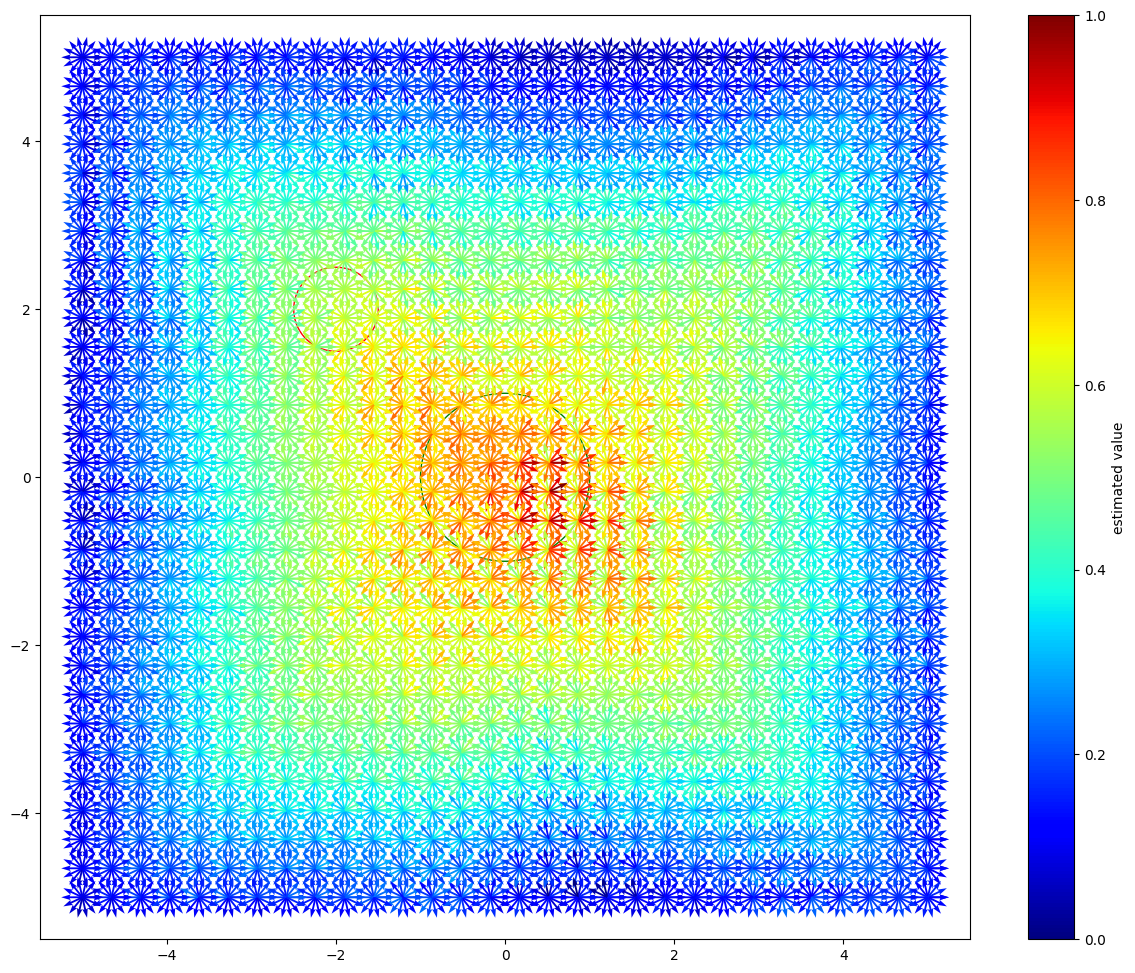

In [49]:
plot_surface(X3, env, 'experiment.png', y_train)

In [50]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-3,3, right)
#state = env.reset()

gamma = gamma
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        #estimate = forward(X=next_state, params=params)
        estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)

        value = reward + gamma*estimate[0]


        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
    
env.make_gif()

1
2
3
4
5
6
7
8
9
10
11
12
13


In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [394]:
forward(X=np.array([-4,-4,1, 1]), params=params) 

Array([1.237214], dtype=float32)

In [393]:
forward(X=np.array([0,0,1, 0]), params=params) 

Array([0.08173393], dtype=float32)

In [392]:
env.step(np.array([0,0,np.pi]), 0, update_env=False)

(array([2.50000000e-01, 4.37113883e-08, 2.00712864e+00]), 100, True, {})

In [166]:
X[0]

array([ 1.8830727 , -1.7482759 ,  0.23815954, -0.97122604], dtype=float32)